In [1]:
%pip install matplotlib
%pip install xgboost
%pip install pytorch-lightning pytorch-forecasting torch --upgrade
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [73]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [74]:
data_source = 'sampleData'

df_lark = pd.read_csv(os.path.join(data_source, 'lark.csv'))
df_sheets = pd.read_csv(os.path.join(data_source, 'sheets.csv'))
df_sheets_archive = pd.read_csv(os.path.join(data_source, 'sheets_archive.csv'))

In [91]:
df_lark["Order Date"] = pd.to_datetime(
    df_lark["Order Date"], 
    format="%Y/%m/%d %H:%M",
    errors="coerce"
)

df_sheets["Order Date"] = pd.to_datetime(df_sheets["Order Date"], errors="coerce")
df_sheets["Order Date"] = df_sheets["Order Date"].dt.tz_localize(None)

df_sheets_archive["Order Date"] = pd.to_datetime(df_sheets_archive["Order Date"], errors="coerce")
df_sheets_archive["Order Date"] = df_sheets_archive["Order Date"].dt.tz_localize(None)

In [92]:
keep_cols = ['Order Date',
 'SKU',
 'Variant',
 'Quantity',
 'Delivery Date']

df_lark = df_lark[keep_cols]
df_sheets = df_sheets[keep_cols]
df_sheets_archive = df_sheets_archive[keep_cols]

In [93]:
df_master = pd.concat([df_lark, df_sheets, df_sheets_archive], ignore_index=True)
df_master.head()

,Order Date,SKU,Variant,Quantity,Delivery Date
0,2025-08-21 18:53:00,SC5,Assembly,1.0,NaN
1,2025-08-21 18:53:00,CU,Soft Close,1.0,NaN
2,2025-08-21 19:50:00,SC5/WAL,Assembly,1.0,NaN
3,2025-08-22 20:04:00,Elite/DivanSet/PU/Queen,Faux Leather,1.0,NaN
4,2025-08-22 20:37:00,SC5/WAL,Assembly,1.0,NaN


In [78]:
df_master.describe()

,Order Date,Quantity
count,1628,1785.000000
mean,2025-04-17 20:54:31.945331712,1.140056
min,2024-04-27 11:41:27,1.000000
25%,2025-01-19 12:09:09,1.000000
50%,2025-03-09 14:05:30,1.000000
75%,2025-07-27 17:42:25,1.000000
max,2025-09-05 20:18:17,20.000000
std,NaN,0.766078


In [79]:
print(df_master["SKU"].value_counts())

SKU
CU                309
SC18/WAL           59
SC5/WAL            48
SC15               45
SC5                41
                 ... 
P4052/3045          1
DC1254/3036WH*      1
SB4301/3036         1
TV24/WH3036         1
CTM11               1
Name: count, Length: 721, dtype: int64


In [80]:
df_master.columns

Index(['Order Date', 'SKU', 'Variant', 'Quantity', 'Delivery Date'], dtype='object')

# Displaying orders over time

In [81]:
monthly_orders = df_master.groupby(
    pd.Grouper(key="Order Date", freq="ME") 
)["Quantity"].sum()

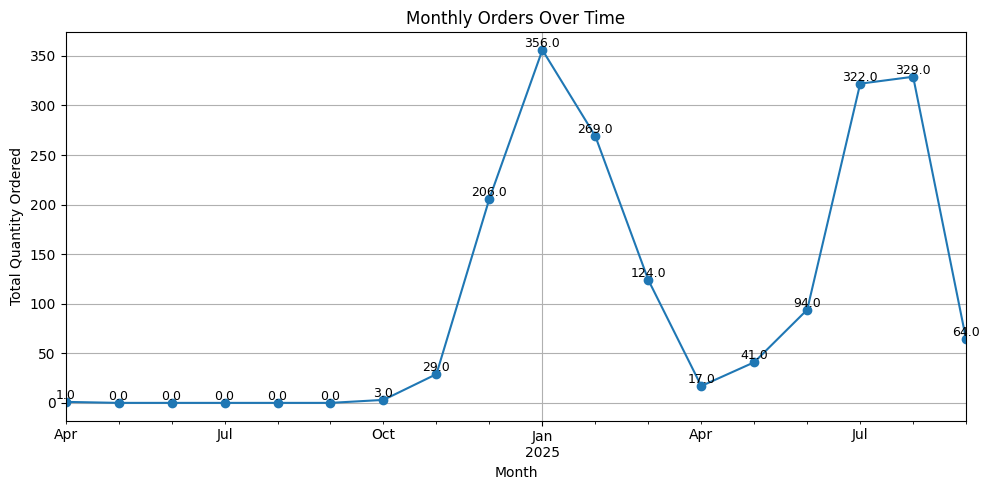

In [82]:
# Plot
plt.figure(figsize=(10, 5))
ax = monthly_orders.plot(marker="o")

# Add data labels
for x, y in zip(monthly_orders.index, monthly_orders.values):
    ax.text(x, y, str(y), ha="center", va="bottom", fontsize=9)

plt.title("Monthly Orders Over Time")
plt.xlabel("Month")
plt.ylabel("Total Quantity Ordered")
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecasting

In [72]:
%pip install xgboost
%pip install scikit-learn

41729.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


41735.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


41740.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


## XGBoost

In [111]:
df_xgboost = df_master
df_xgboost.columns

Index(['Order Date', 'SKU', 'Variant', 'Quantity', 'Delivery Date'], dtype='object')

In [112]:
df_xgboost = df_xgboost.dropna(subset=["Order Date"])

In [113]:
df_monthly = (
    df_xgboost.groupby(["SKU", pd.Grouper(key="Order Date", freq="M")])["Quantity"]
      .sum()
      .reset_index()
      .sort_values(["SKU", "Order Date"])
)

display(df_monthly)

/var/folders/tk/ptln5ljx66g1yqhg_dd36_200000gn/T/ipykernel_11579/3046609257.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_xgboost.groupby(["SKU", pd.Grouper(key="Order Date", freq="M")])["Quantity"]


,SKU,Order Date,Quantity
0,10057207,2025-03-31,1.0
1,10172886,2025-02-28,1.0
2,1039 Pull Out/SS-S/PL016,2025-06-30,2.0
3,1045 Storage Bed/Single/omi02,2025-02-28,2.0
4,1045 Storage Bed/Single/omi05,2025-02-28,2.0
...,...,...,...
773,Zara/Divan/Queen/PL-012,2025-04-30,4.0
774,Zara/King/ME005,2025-02-28,2.0
775,Zara/Storage/Queen/ME002,2025-06-30,4.0
776,Zara/Storage/Queen/ML07,2025-06-30,1.0


In [115]:
df_monthly["year"] = df_monthly["Order Date"].dt.year
df_monthly["month"] = df_monthly["Order Date"].dt.month

df_monthly["lag_1"] = df_monthly.groupby("SKU")["Quantity"].shift(1)
df_monthly["lag_3"] = df_monthly.groupby("SKU")["Quantity"].shift(3)
df_monthly["rolling_mean_3"] = (
    df_monthly.groupby("SKU")["Quantity"].shift(1).rolling(3).mean()
)

df_monthly["sku_id"] = df_monthly["SKU"].astype("category").cat.codes

df_monthly = df_monthly.dropna()


DF_monthly is engineered in the following way
- Col for demand from 1 month ago
- Col for demand from 3 months ago
- Col for average demand over past 3 months
- "SKU" is encoded to a numeric code "sku_id"

In [116]:
display(df_monthly)

,SKU,Order Date,Quantity,year,month,lag_1,lag_3,rolling_mean_3,sku_id
90,CH,2025-03-31,5.0,2025,3,10.0,2.0,6.666667,82
91,CH,2025-05-31,5.0,2025,5,5.0,8.0,7.666667,82
92,CH,2025-06-30,2.0,2025,6,5.0,10.0,6.666667,82
93,CH,2025-07-31,2.0,2025,7,2.0,5.0,4.000000,82
94,CH,2025-08-31,12.0,2025,8,2.0,5.0,3.000000,82
244,CU,2025-01-31,72.0,2025,1,49.0,1.0,19.666667,229
245,CU,2025-02-28,61.0,2025,2,72.0,9.0,43.333333,229
246,CU,2025-03-31,27.0,2025,3,61.0,49.0,60.666667,229
247,CU,2025-04-30,3.0,2025,4,27.0,72.0,53.333333,229
248,CU,2025-05-31,3.0,2025,5,3.0,61.0,30.333333,229


In [138]:
from sklearn.model_selection import train_test_split

X = df_monthly[["sku_id", "year", "month", "lag_1", "lag_3", "rolling_mean_3"]]
y = df_monthly["Quantity"]

# Split chronologically, not randomly
split_date = "2025-07-31"
X_train = X[df_monthly["Order Date"] < split_date]
y_train = y[df_monthly["Order Date"] < split_date]
X_test = X[df_monthly["Order Date"] >= split_date]
y_test = y[df_monthly["Order Date"] >= split_date]

In [139]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist"
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # convert to %
print("MAPE: {:.2f}%".format(mape))


MAPE: 85.51%


In [140]:
dfm = df_monthly.copy()
dfm["Month"] = dfm["Order Date"].dt.to_period("M")

summary = (
    dfm.groupby("Month")
       .agg(
           rows=("Quantity", "size"),                     # number of SKU-month rows
           skus=("SKU", "nunique"),                       # unique SKUs active that month
           total_qty=("Quantity", "sum"),                 # total demand that month
           median_qty=("Quantity", "median"),             # median SKU demand that month
       )
       .reset_index()
       .sort_values("Month")
)

summary["cum_rows"] = summary["rows"].cumsum()
summary["rem_rows"] = summary["rows"][::-1].cumsum()[::-1]
summary["cum_months"] = np.arange(1, len(summary)+1)
summary["rem_months"] = summary["cum_months"].iloc[::-1].values

display(summary)

,Month,rows,skus,total_qty,median_qty,cum_rows,rem_rows,cum_months,rem_months
0,2025-01,1,1,72.0,72.0,1,55,1,9
1,2025-02,2,2,63.0,31.5,3,54,2,8
2,2025-03,11,11,57.0,3.0,14,52,3,7
3,2025-04,2,2,4.0,2.0,16,41,4,6
4,2025-05,2,2,8.0,4.0,18,39,5,5
5,2025-06,2,2,12.0,6.0,20,37,6,4
6,2025-07,14,14,119.0,3.5,34,35,7,3
7,2025-08,13,13,159.0,9.0,47,21,8,2
8,2025-09,8,8,27.0,3.0,55,8,9,1


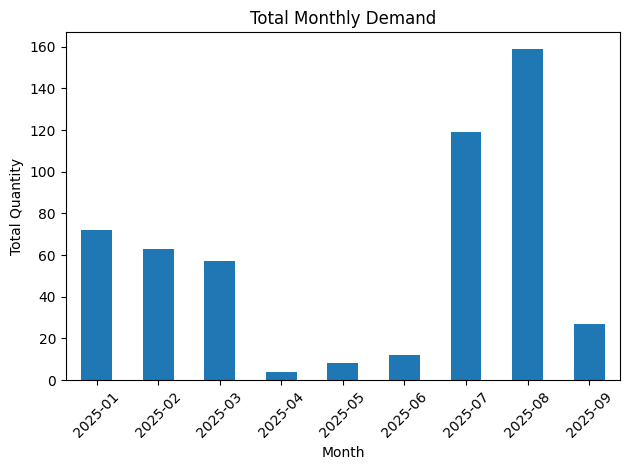

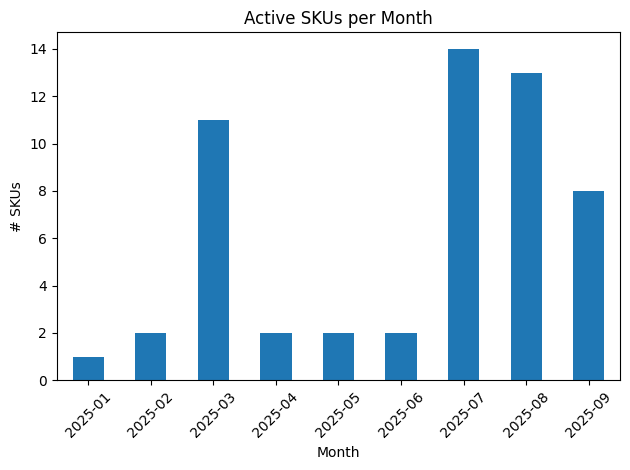

In [141]:
# total demand per month
ax = summary.set_index(summary["Month"].astype(str))["total_qty"].plot(kind="bar", rot=45)
ax.set_title("Total Monthly Demand")
ax.set_xlabel("Month")
ax.set_ylabel("Total Quantity")
plt.tight_layout()
plt.show()

# number of active SKUs per month
ax = summary.set_index(summary["Month"].astype(str))["skus"].plot(kind="bar", rot=45)
ax.set_title("Active SKUs per Month")
ax.set_xlabel("Month")
ax.set_ylabel("# SKUs")
plt.tight_layout()
plt.show()


# TFT

43044.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 20.1 MB/s  0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.4
    Uninstalling pytorch-lightning-2.5.4:
      Successfully uninstalled pytorch-lightning-2.5.4
Note: you may need to restart the kernel to use updated packages.


In [156]:
df_master.columns

Index(['Order Date', 'SKU', 'Variant', 'Quantity', 'Delivery Date'], dtype='object')

In [157]:
df_tft = df_master.copy()

In [158]:
df_tft["Order Date"] = pd.to_datetime(df_tft["Order Date"], errors="coerce")
df_tft = df_tft.dropna(subset=["Order Date"])

In [161]:
df_tft_monthly = (
    df_tft.groupby(["SKU", pd.Grouper(key="Order Date", freq="ME")])["Quantity"]
      .sum()
      .reset_index()
      .rename(columns={"Order Date": "date", "Quantity": "y"})
)

print(df_tft_monthly.columns)
print(df_tft_monthly.describe())

Index(['SKU', 'date', 'y'], dtype='object')
                                date           y
count                            778  778.000000
mean   2025-04-27 14:13:15.886889472    2.194087
min              2024-04-30 00:00:00    1.000000
25%              2025-01-31 00:00:00    1.000000
50%              2025-03-31 00:00:00    1.000000
75%              2025-07-31 00:00:00    2.000000
max              2025-09-30 00:00:00   72.000000
std                              NaN    5.327341


In [162]:
all_months = pd.period_range(df_tft_monthly["date"].min().to_period("M"),
                             df_tft_monthly["date"].max().to_period("M"), freq="M").to_timestamp("M")

grid = (
    df_tft_monthly[["SKU"]].drop_duplicates()
    .assign(key=1)
    .merge(pd.DataFrame({"date": all_months, "key":1}), on="key")
    .drop("key", axis=1)
)

df_tft_monthly = grid.merge(df_tft_monthly, on=["SKU","date"], how="left")
df_tft_monthly["y"] = df_tft_monthly["y"].fillna(0.0)

In [165]:
# ensure datetime
df_tft_monthly["date"] = pd.to_datetime(df_tft_monthly["date"], errors="coerce")

base_y = df_tft_monthly["date"].min().year
base_m = df_tft_monthly["date"].min().month

# 0,1,2,... increasing by 1 per month
df_tft_monthly["time_idx"] = (df_tft_monthly["date"].dt.year - base_y) * 12 + \
                             (df_tft_monthly["date"].dt.month - base_m)

# calendar features
df_tft_monthly["month"] = df_tft_monthly["date"].dt.month.astype(int)
df_tft_monthly["year"]  = df_tft_monthly["date"].dt.year.astype(int)


In [166]:
split_time = df_tft_monthly.loc[df_tft_monthly["date"] <= "2025-07-31", "time_idx"].max()
train = df_tft_monthly[df_tft_monthly["time_idx"] <= split_time]
valid = df_tft_monthly[df_tft_monthly["time_idx"] >  split_time]

In [167]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder

max_encoder_length = 6    # look-back months
max_prediction_length = 1 # predict 1 month ahead

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="y",
    group_ids=["SKU"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["SKU"],                 # SKU identity
    time_varying_known_reals=["time_idx","month","year"],
    time_varying_unknown_reals=["y"],
    categorical_encoders={"SKU": NaNLabelEncoder().fit(df_tft_monthly["SKU"])},
)

validation = TimeSeriesDataSet.from_dataset(training, valid, predict=True, stop_randomization=True)

from torch.utils.data import DataLoader
train_loader = DataLoader(training, batch_size=64, shuffle=True)
val_loader   = DataLoader(validation, batch_size=64)

In [ ]:
import pytorch_lightning as pl
from pytorch_forecasting.models import TemporalFusionTransformer

pl.seed_everything(42)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
)

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    logger=False,
    enable_checkpointing=False,
)

trainer.fit(tft, train_loader, val_loader)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# predictions
y_pred = tft.predict(val_loader).detach().cpu().numpy().ravel()

# ground truth
y_true = torch.cat([y[0] for _, y in iter(val_loader)]).numpy().ravel()

# compute MAPE
mask = y_true != 0
mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100
print(f"MAPE: {mape:.2f}%")
